### Using Node2vec + Kmeans to detect communities in graphs
we used embeddings vectors generated using node2vec model, 
we train then kmeans models to do clustering on the data generated. 
the partition resulted from Kmeans will be directely maped to the graph corresponding to its embedding.


In [10]:
# reading graph edges from bigQuery tables 
from google.cloud import bigquery
from scipy.sparse import csr_matrix
import numpy as np 
from google.cloud import storage
from google.cloud import bigquery
from pyspark.sql import *
from pyspark.sql.functions import split
import pandas as pd
from scipy.io import mmwrite
import networkx as nx
import time 
from copy import deepcopy
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder \
  .appName('data-preparation')\
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
  .getOrCreate()

#### step One: 
we try to train foreach value of k (in interval around the number of communities found by louvain) a model for which we compute the mean silhouette score on the partition. 

In [11]:
# Loads data.
files = ['CA-AstroPh', 'CA-GrQc',  'CA-HepPh', 'CA-HepTh' ]
# the bucket where we store the edges of each dataset in cloud storage 
BUCKET_NAME = 'rplace-bucket'
number_communities_louvain = [324, 392, 318, 480]
# we performe number of clusters K search on the intervals of [l - 10, l + 10]
scores = dict()
allKs  = dict()
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [ ]:
g = 0
elepses = []
for file in files:
    print("preparing the data of {}".format(file))
    dataset = spark.read.option("header","true").format("csv").load(f"gs://"+ \
                            BUCKET_NAME+"/embeddings/embedding."+file)
    header = dataset.columns
    nodes = int(header[0].split(' ')[0])
    dimensions = int(header[0].split(' ')[1])
    split_col = split(dataset[header[0]], ' ')
    dataset   = dataset.withColumn('id', split_col.getItem(0))
    dataset = dataset.withColumn("id",dataset.id.cast('int'))
    for i in range(dimensions):
        dataset = dataset.withColumn('d' + str(i), split_col.getItem(i+1))
        dataset = dataset.withColumn('d' + str(i),dataset['d' + str(i)].cast('float'))
    dataset = dataset.drop(header[0])
    
    scaler = StandardScaler(inputCol="features", \
                    outputCol="scaledFeatures",
                    withStd=True, withMean=True)
    
    assembler = VectorAssembler(inputCols=['d' + str(i) for i in range(dimensions)], outputCol = 'features')
    featureDf = assembler.transform(dataset)
    scalerModel = scaler.fit(featureDf)
    scaledDf = scalerModel.transform(featureDf)
    
    Ks = [number_communities_louvain[g] - i for i in range(30)] + \
        [i+number_communities_louvain[g] for i in range(30)]
    Ks.sort()
    allKs[file] = deepcopy(Ks)
    g+=1
    score = []
    print("kmeans job starts on {}".format(file))
    start = time.time()
    for k in Ks:
        kmeans = KMeans().setK(k).setFeaturesCol("scaledFeatures").setPredictionCol("prediction")
        kmeansModel = kmeans.fit(scaledDf)
        predictDf = kmeansModel.transform(scaledDf)
        score.append(evaluator.evaluate(predictDf))
        if(k%10 == 0):
            print(f"graph {file} --- k = [{k}] silhouette score {score[-1]}")
    elepse = time.time() - start 
    elepses.append(elepse)
    scores[file] = score
    print("Job on graph {} terminated ".format(file))
    print("time elepsed {}".format(elepse))

preparing the data of CA-AstroPh
kmeans job starts on CA-AstroPh
graph CA-AstroPh --- k = [300] silhouette score 0.23715911129785777
graph CA-AstroPh --- k = [310] silhouette score 0.243486115493207
graph CA-AstroPh --- k = [320] silhouette score 0.2486282780182678
graph CA-AstroPh --- k = [330] silhouette score 0.25231058762879416
graph CA-AstroPh --- k = [340] silhouette score 0.2468321719352409
graph CA-AstroPh --- k = [350] silhouette score 0.24772711538849912
Job on graph CA-AstroPh terminated 
time elepsed 1232.2256104946136
preparing the data of CA-GrQc
kmeans job starts on CA-GrQc
graph CA-GrQc --- k = [370] silhouette score 0.455407512284632
graph CA-GrQc --- k = [380] silhouette score 0.47233230341487537
graph CA-GrQc --- k = [390] silhouette score 0.4697747708262412
graph CA-GrQc --- k = [400] silhouette score 0.476840557711411
graph CA-GrQc --- k = [410] silhouette score 0.46753811294213876
graph CA-GrQc --- k = [420] silhouette score 0.47829604909492324
Job on graph CA-GrQ

#### Step two:
choosing the value of k that maximize the mean silhouette score foreach graph 

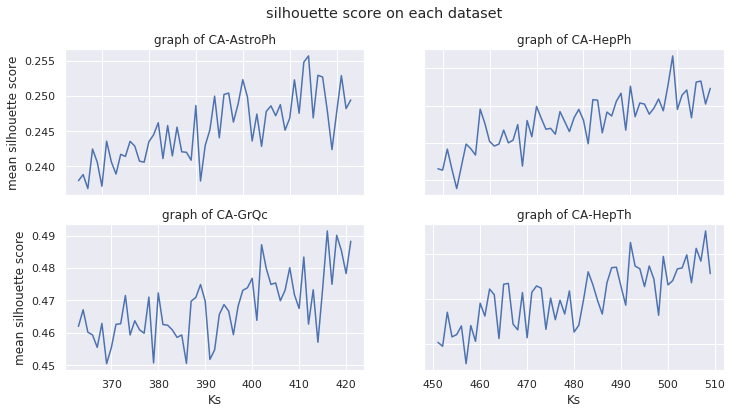

In [24]:
from matplotlib import pyplot as plt
cm = 1/2.54
fig, axes = plt.subplots(2, 2, figsize=(30*cm, 15*cm))
fig.suptitle('silhouette score on each dataset')
i = 0
j = 0
for file in files:
    if(i>=2):
        j = 1
    axes[i%2,j].set_title(f"graph of {file}")
    score = scores[file]
    # score.sort(reverse= True)
    axes[i%2,j].plot(allKs[file],score)
    i+=1
for ax in axes.flat:
    ax.set(xlabel='Ks', ylabel='mean silhouette score')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()       

In [23]:
K = dict()
for file in files:
    i = scores[file].index(max(scores[file])) 
    K[file] = allKs[file][i]
print("optimal number of clusters based on silhouette score :\n \t {}".format(K))

optimal number of clusters based on silhouette score :
 	 {'CA-AstroPh': 344, 'CA-GrQc': 416, 'CA-HepPh': 339, 'CA-HepTh': 508}


#### Step three 
we train another time kmeans models with k given in the last step
we save then the resulting partitions foreach graph

In [43]:
pred = dict()
nodesIds = dict()
for file in files:
    print("preparing the data of {}".format(file))
    dataset = spark.read.option("header","true").format("csv").load(f"gs://"+ \
                            BUCKET_NAME+"/embeddings/embedding."+file)
    header = dataset.columns
    nodes = int(header[0].split(' ')[0])
    dimensions = int(header[0].split(' ')[1])
    split_col = split(dataset[header[0]], ' ')
    dataset   = dataset.withColumn('id', split_col.getItem(0))
    dataset = dataset.withColumn("id",dataset.id.cast('int'))
    for i in range(dimensions):
        dataset = dataset.withColumn('d' + str(i), split_col.getItem(i+1))
        dataset = dataset.withColumn('d' + str(i),dataset['d' + str(i)].cast('float'))
    dataset = dataset.drop(header[0])
    
    scaler = StandardScaler(inputCol="features", \
                    outputCol="scaledFeatures",
                    withStd=True, withMean=True)
    
    assembler = VectorAssembler(inputCols=['d' + str(i) for i in range(dimensions)], outputCol = 'features')
    featureDf = assembler.transform(dataset)
    nodesIds[file] = featureDf.toPandas()['id']
    scalerModel = scaler.fit(featureDf)
    scaledDf = scalerModel.transform(featureDf)

    print("kmeans job starts on {}".format(file))
    kmeans = KMeans().setK(K[file]).setFeaturesCol("scaledFeatures").setPredictionCol("prediction")
    kmeansModel = kmeans.fit(scaledDf)
    predictDf = kmeansModel.transform(scaledDf)
    pred[file] = predictDf.select("prediction").rdd.flatMap(lambda x: x).collect()   
    print("Job on graph {} terminated ".format(file))

preparing the data of CA-AstroPh
kmeans job starts on CA-AstroPh
Job on graph CA-AstroPh terminated 
preparing the data of CA-GrQc
kmeans job starts on CA-GrQc
Job on graph CA-GrQc terminated 
preparing the data of CA-HepPh
kmeans job starts on CA-HepPh
Job on graph CA-HepPh terminated 
preparing the data of CA-HepTh
kmeans job starts on CA-HepTh
Job on graph CA-HepTh terminated 


In [45]:
g = 0
for file in files : 
    Y = pred[file]
    ids = nodesIds[file]
    with open("kmeans_node_to_community." + file, "w") as f:
        for i in range(ids.shape[0]) : 
            iid = ids[i]
            c = Y[i]
            f.write(str(iid) + ":" + str(c)+"\n")
        f.write("Time_of_execution:"+ str(elepses[g]))
        g+=1


In [47]:
! gsutil cp ./kmeans_node_to_community.* gs://rplace-bucket/results

Copying file://./kmeans_node_to_community.CA-AstroPh [Content-Type=application/octet-stream]...
Copying file://./kmeans_node_to_community.CA-GrQc [Content-Type=application/octet-stream]...
Copying file://./kmeans_node_to_community.CA-HepPh [Content-Type=application/octet-stream]...
Copying file://./kmeans_node_to_community.CA-HepTh [Content-Type=application/octet-stream]...
/ [4 files][395.0 KiB/395.0 KiB]                                                
Operation completed over 4 objects/395.0 KiB.                                    
